# 1. Load data

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
from sklearn.utils import shuffle

from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import GradientBoostingClassifier

pd.options.mode.chained_assignment = None
sns.mpl.rc("figure", figsize=(15,8))

df_base = pd.read_csv('bank-classification.csv')

# Change type of results column
df_base.y.replace(('yes', 'no'), (1, 0), inplace=True)

print df_base[:10]

/home/hubert/Documents/jnp3/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


   id  birth_date          job  marital            education  default housing  \
0   1  1952-03-23    housemaid  married             basic.4y       no      no   
1   2  1951-03-24     services  married          high.school  unknown      no   
2   3  1971-05-19     services  married          high.school       no     yes   
3   4  1968-01-24       admin.  married             basic.6y       no      no   
4   5  1952-05-11     services  married          high.school       no      no   
5   6  1963-05-01     services  married             basic.9y  unknown      no   
6   7  1949-08-09       admin.  married  professional.course       no      no   
7   8  1967-04-15  blue-collar  married              unknown  unknown      no   
8   9  1984-05-17   technician   single  professional.course       no     yes   
9  10  1983-02-15     services   single          high.school       no     yes   

  loan contact_date    contact  campaign  pdays  previous     poutcome  \
0   no   2008-05-12  telephone    

# 2. Data visualization

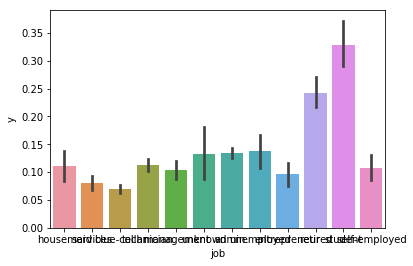

In [3]:
df = df_base
learn = df.loc[df['y'] != 'unknown']
learn['y'] = learn['y'].astype('int64')

sns.barplot(x='job', y='y', data=learn)
plt.show()

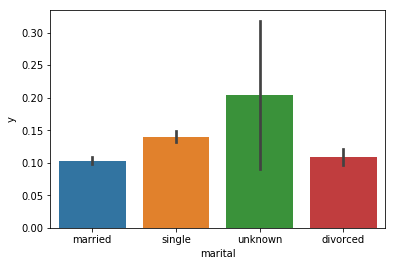

In [4]:
sns.barplot(x='marital', y='y', data=learn)
plt.show()

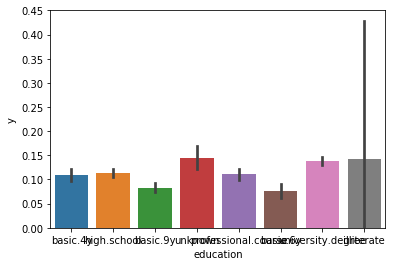

In [5]:
sns.barplot(x='education', y='y', data=learn)
plt.show()

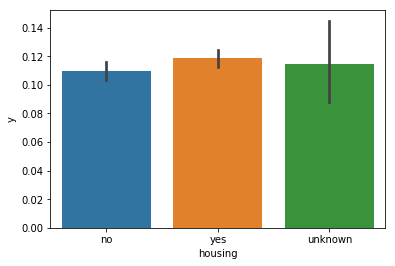

In [6]:
sns.barplot(x='housing', y='y', data=learn)
plt.show()

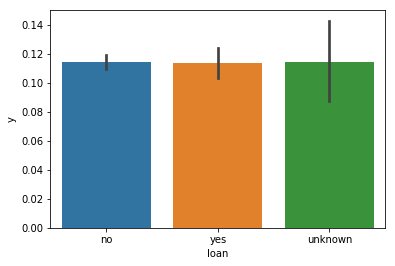

In [7]:
sns.barplot(x='loan', y='y', data=learn)
plt.show()

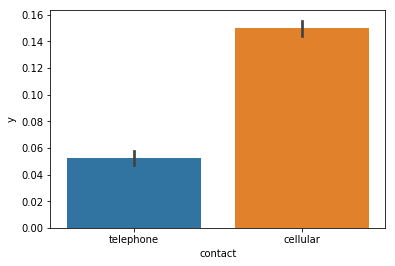

In [8]:
sns.barplot(x='contact', y='y', data=learn)
plt.show()

### Pdays - number of days that passed by after the client was last contacted from a previous campaign

Too big variances to not combine one hot features

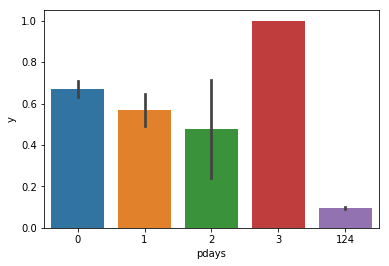

In [9]:
df = df_base
learn = df.loc[df['y'] != 'unknown']
learn['y'] = learn['y'].astype('int64')

learn['pdays'] = learn['pdays'].apply(lambda x: x/8)
sns.barplot(x='pdays', y='y', data=learn)
plt.show()

### Campaign - number of contacts performed during this campaign and for this client (numeric, includes last contact)

Higher-number days have too big variance, so it seems to be reasonable to combine them into common features.

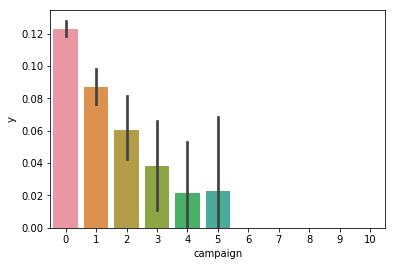

In [10]:
df = df_base
learn = df.loc[df['y'] != 'unknown']
learn['y'] = learn['y'].astype('int64')

learn['campaign'] = learn['campaign'].apply(lambda x: x/4)
sns.barplot(x='campaign', y='y', data=learn)


plt.show()

### Contact_date

Contact date, when splitted in 6-month periods, looks like great feature. Quite big differences between periods and low deviation.

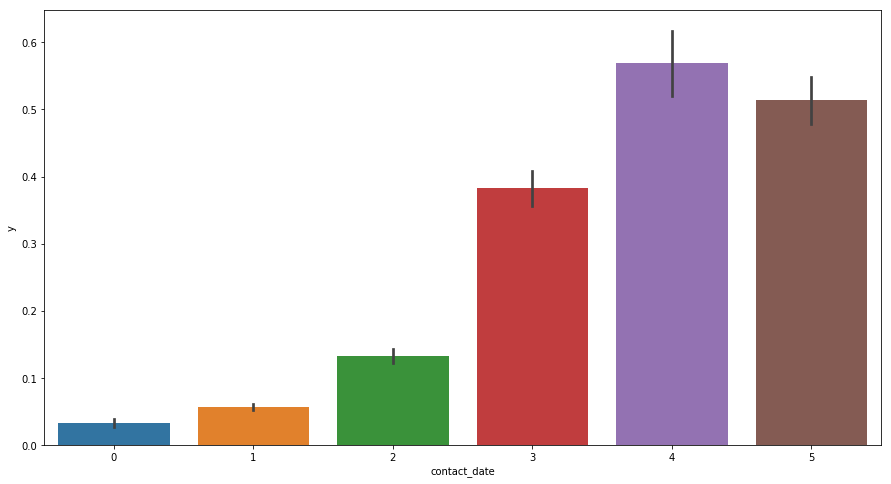

In [48]:
df = df_base
learn = df.loc[df['y'] != 'unknown']
learn['y'] = learn['y'].astype('int64')

learn['contact_date'] = pd.to_datetime(learn['contact_date'], format='%Y-%m-%d')
learn['contact_date'] = learn['contact_date'].apply(lambda x: (x.month + (x.year-2008)*12)/6)
sns.barplot(x='contact_date', y='y', data=learn)
plt.show()

# 3. Feature engineering

In [11]:
df = df_base

# Drop month and day of birth
df['birth_date'] = df['birth_date'].apply(lambda x: x.split('-')[0])


df['contact_date'] = pd.to_datetime(learn['contact_date'], format='%Y-%m-%d')
df['contact_date'] = df['contact_date'].apply(lambda x: (x.month + (x.year-2008)*12)/6)
learn['pdays'] = learn['pdays'].apply(lambda x: x/8)
learn['campaign'] = learn['campaign'].apply(lambda x: x/4)

one_hot_columns = ['marital', 'education', 'default', 'housing', 'contact', 'poutcome', 'job', 'campaign', 'contact_date'] #'loan',  
df = pd.get_dummies(df, columns=one_hot_columns)


print df.dtypes

len(df)

id                                int64
birth_date                       object
loan                             object
pdays                             int64
previous                          int64
y                                object
marital_divorced                  uint8
marital_married                   uint8
marital_single                    uint8
marital_unknown                   uint8
education_basic.4y                uint8
education_basic.6y                uint8
education_basic.9y                uint8
education_high.school             uint8
education_illiterate              uint8
education_professional.course     uint8
education_university.degree       uint8
education_unknown                 uint8
default_no                        uint8
default_unknown                   uint8
default_yes                       uint8
housing_no                        uint8
housing_unknown                   uint8
housing_yes                       uint8
contact_cellular                  uint8


41188

# 4. Learning

In [12]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['y'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['y'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['y'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['y'], dtrain_predprob)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [14]:
# Split data into learning and testing rows
learn = df.loc[df['y'] != 'unknown']
test = df.loc[df['y'] == 'unknown']
learn = shuffle(learn)

learn['y'] = learn['y'].astype('int64')

#predicators = ['contact_cellular', 'contact_telephone', 'poutcome_success', 'poutcome_nonexistent', 'poutcome_nonexistent', 'loan_no', 'loan_yes', 'loan_unknown', 'housing_unknown', 'housing_yes', 'housing_no', 'previous', 'default_no', 'default_yes', 'default_unknown']
predictors = [x for x in learn.columns if x not in ['y', 'pdays', 'id', 'loan']]
params_ranges = {'n_estimators': [40, 500],
                 'min_samples_split': [150, 500],
                 'min_samples_leaf': [50, 100],
                 'max_depth': [5, 8]}

classifier = GradientBoostingClassifier(learning_rate=0.1, max_features='sqrt', subsample=0.8, random_state=10)
gsearch1 = RandomizedSearchCV(estimator = classifier, param_distributions=params_ranges, scoring='roc_auc', n_jobs=8, iid=False, cv=5)

gsearch1.fit(learn[predictors], learn['y'])

print gsearch1.best_params_, gsearch1.best_score_


{'n_estimators': 40, 'min_samples_split': 500, 'max_depth': 5, 'min_samples_leaf': 100} 0.780307799438


In [ ]:
modelfit(gsearch1, learn, predictors)

# 5. Predict

In [ ]:
test = df.loc[df['y'] == 'unknown']
results = gsearch5.predict(test[predictors])
test['y'] = results
test[['id', 'y']].to_csv("results.csv", encoding='utf-8', index=False)